# A simple ripple carry adder on the QPU

In this notebook use a "simple" reversible binary adder to benchmark a quantum computer. The code is contained in the module `classical_logic`.

The benchmark is simplistic and not very rigorous as it does not test any specific feature of the hardware. Further the whole circuit is classical in the sense that we start and end in computational basis states and all gates simply perform classical not, controlled not (`CNOT`), or doubly controlled not (`CCNOT` aka a [Toffoli gate](https://en.wikipedia.org/wiki/Toffoli_gate)). Finally, even for the modest task of adding two one bit numbers, the `CZ` gate (our fundamental two qubit gate) count is very high for the circuit. This in turn implies a low probablity of the entire circuit working.

However it is very easy to explain the performance of hardware to non-experts, e.g. *"At the moment quantum hardware is pretty noisy, so much so that when we run circuits to add two classical bits it gives the correct answer 40% of the time."*

Moreover the simplicity of the benchmark is also its strength. At the bottom of this notebook we provide code for examining the "error distribution". When run on hardware we can observe that low weight errors dominate which gives some insight that the hardware is approximately doing the correct thing.

The module  `classical_logic` is based on the circuits found in  

*A new quantum ripple-carry addition circuit*,   
Cuccaro, Draper, Kutin, and Moulton.  
https://arxiv.org/abs/quant-ph/0410184v1.  



![alt txt](figs/binary_adder.png) Figures from Cuccaro et al. https://arxiv.org/abs/quant-ph/0410184v1

In [1]:
import numpy as np
from pyquil.quil import Program

from pyquil.gates import *
from pyquil.api import get_qc
from forest.benchmarking.classical_logic.ripple_carry_adder import *

import matplotlib.pyplot as plt
import networkx as nx

In [2]:
# noiseless QVM
qc = get_qc("9q-generic", as_qvm=True, noisy=False)

# noisy QVM
noisy_qc = get_qc("9q-generic-noisy-qvm", as_qvm=True, noisy=True)

## Draw the noiseless qc topology

/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


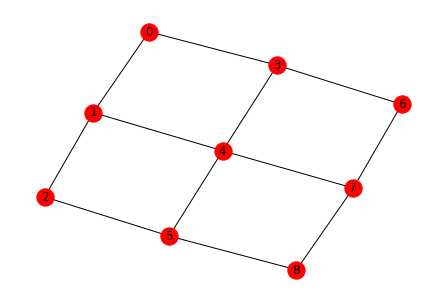

In [3]:
nx.draw(qc.qubit_topology(),with_labels=True)

## One bit addtion: 1+1 = 10  i.e.  2

There is a small bit of setup that needs to happen before creating the program for the circuit. Specifically you have to pick registers of qubits for the two input numbers `reg_a` and `reg_b`, a carry bit `c`, and an extra digit `z` that will hold the most significant bit of the answer.

If you have a specific line of qubits in mind for the registers there is a helper `assign_registers_to_line_or_cycle()` which will provide these registers for you--`c` is assigned to the provided start qubit and assignments go down the line in the circuit diagram above; however, you have to provide a subgraph that is sufficiently simple so that the assignment can be done by simpling moving to the next neighbor--e.g. the graph is a line or a cycle. 

If you don't care about the particular arrangment of qubits then you can instead use `get_qubit_registers_for_adder()` which will find a suitable assignment for you if one exists.

In [4]:

# the input numbers
num_a = [1]
num_b = [1]

# There are two easy routes to assign registers

# 1) if you have particular target qubits in mind
target_qubits = [3,6,7,4,1]
start = 3
reg_a, reg_b, c, z = assign_registers_to_line_or_cycle(start, 
                                                       qc.qubit_topology().subgraph(target_qubits), 
                                                       len(num_a))
print('Registers c, a, b, z on target qubits', target_qubits,': ', c, reg_a, reg_b, z)

# 2) if you don't care about a particular arrangement
# you can still exclude qubits. Here we exclude 0.
reg_a, reg_b, c, z = get_qubit_registers_for_adder(qc, len(num_a), qubits = list(range(1,10)))
print('Registers c, a, b, z on any qubits excluding q0: ', c, reg_a, reg_b, z)


# given the numbers and registers construct the circuit to add
ckt = adder(num_a, num_b, reg_a, reg_b, c, z)
exe = qc.compile(ckt)
result = qc.run(exe)

print('\nThe answer of 1+1 is 10')
print('The circuit on an ideal qc gave: ', result)

Registers c, a, b, z on target qubits [3, 6, 7, 4, 1] :  3 [7] [6] 4
Registers c, a, b, z on any qubits excluding q0:  4 [2] [1] 5

The answer of 1+1 is 10
The circuit on an ideal qc gave:  [[1 0]]


## Two bit addition

We will start with 1+1=2 on a noiseless simulation.

We choose to represent 1 (decimal) as a two digit binary number 01 so the addition becomes

01 + 01 = 010 

where the bits are ordered from most significant to least i.e. (MSB...LSB).

The MSB is necessary for representing other two bit additions e.g. 2 + 2 = 4  -> 10 + 10 = 100


In [5]:
# the input numbers
num_a = [0,1]
num_b = [0,1]

# 
reg_a, reg_b, c, z = get_qubit_registers_for_adder(qc, len(num_a))

# given the numbers and registers construct the circuit to add
ckt = adder(num_a, num_b, reg_a, reg_b, c, z)
exe = qc.compile(ckt)
result = qc.run(exe)

print('The answer of 01+01 is 010')
print('The circuit on an ideal qc gave: ', result)

The answer of 01+01 is 010
The circuit on an ideal qc gave:  [[0 1 0]]


## Draw the noisy qc topology

/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:518: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/home/kylegulshen/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:565: MatplotlibDeprecationWarning: 
The is_numlike function was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use isinstance(..., numbers.Number) instead.
  if cb.is_numlike(alpha):


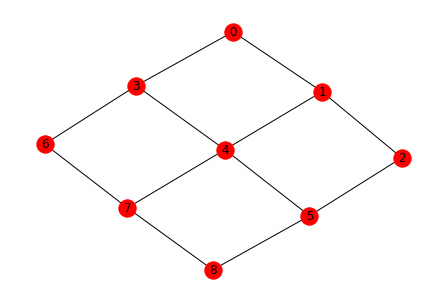

In [6]:
nx.draw(noisy_qc.qubit_topology(),with_labels=True)

## Now try 1+1=2 on a noisy qc
The output is now stochastic--try re-running this cell multiple times!
Note in particular that the MSB is sometimes (rarely) 1 due to some combination of readout error and error propogation through the CNOT

In [7]:
reg_a, reg_b, c, z = get_qubit_registers_for_adder(noisy_qc, len(num_a))
ckt = adder(num_a, num_b, reg_a, reg_b, c, z)
exe = noisy_qc.compile(ckt)
noisy_qc.run(exe)

array([[0, 1, 1]])

## Get results for all summations of pairs of 2-bit strings

Because classical binary addition is easy we can caculate the ideal output of the circuit. In order to see how well the QPU excutes the circuit we average the circuit over all possible input strings. Here we look at two bit strings e.g.


 
| Register a| Register b| a + b + carry|
|-----------|-----------|--------------|
| 00        | 00        | 000          |
| 00        | 01        | 001          |
| 00        | 10        | 010          |
| 00        | 11        | 011          |
| 01        | 00        | 001          |
| $\vdots$  | $\vdots$  | $\vdots$     |
| 11        | 11        | 110          |

The rough measure of goodness is the success probablity, which we define as number of times the QPU correctly returns the string listed in the (a+b+carry) column divided by the total number of trials.

You might wonder how well you can do just by generating a random binary number and reporting that as the answer.
Well if you are doing addition of two $n$ bit strings the probablity that you can get the correct answer by guessing 

$\Pr({\rm correct}\, |\, n)= 1/ 2^{n +1}$,

explicilty $\Pr({\rm correct}\, |\, 1)= 0.25$ and $\Pr({\rm correct}\, |\, 2)= 0.125$.

A zeroth order performance criterion is to do better than these numbers.


In [8]:
n_bits = 2
nshots = 100
results = get_n_bit_adder_results(noisy_qc, n_bits, use_param_program=False, num_shots = nshots, 
                                  show_progress_bar=True)

100%|██████████| 16/16 [00:35<00:00,  2.21s/it]


In [9]:
# sucess probabilities of different input strings
pr_correct = get_success_probabilities_from_results(results)

print('The probablity of getting the correct answer for each output in the above table is:')
print(np.round(pr_correct, 4),'\n')
print('The sucess probality averaged over all inputs is', np.round(np.mean(pr_correct), 5))

The probablity of getting the correct answer for each output in the above table is:
[0.61 0.59 0.63 0.59 0.53 0.53 0.55 0.59 0.5  0.49 0.61 0.54 0.62 0.6
 0.6  0.62] 

The sucess probality averaged over all inputs is 0.575


In [10]:
# For which outputs did we do better than random ?
np.asarray(pr_correct)> 1/2**(n_bits+1)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True])

## Get the distribution of the hamming weight of errors

Even if the sucess probablity of the circuit is worse than random there might be a way in which the circuit is not absolutely random. This could indicate that the computation is actualling doing something 'close' to what is desired. To look for such situations we consider the full distribution of errors in our outputs.

The output of our circuit is in the computational basis so all errors manifest as bit flips from the actual answer. The number of bits you need to flip to transform one binary string $B_1$ to another binary string $B_2$ is called the Hamming distance. We are interested in the distance ${\rm dist}(B_t, B_o)$ between the true ideal answer $B_{t}$ and the noisy output answer $B_{o}$, which is equivalent to the Hamming weight ${\rm wt}(\cdot) $ of the error in our output. 

For example, for various ideal answers and measured outputs for 4 bit addition (remember there's an extra fifth MSB for the answer) we have

${\rm dist}(00000,00001) = {\rm wt}(00001) = 1$


${\rm dist}(00000,10001) = {\rm wt}(10001) = 2$


${\rm dist}(11000,10101) = {\rm wt}(01101) = 3$


${\rm dist}(00001,11110) = {\rm wt}(11111) = 5$


In order to see if our near term devices are doing interesting things we calculate the distrubition of the Hamming weight of the errors observed in our QPU data with respect to the known ideal output. The entry corresponding to zero Hamming weight is the sucess probablity.

In [11]:
distributions = get_error_hamming_distributions_from_results(results)

## Plot distribution of 00+00 and 11+11 and compare to random

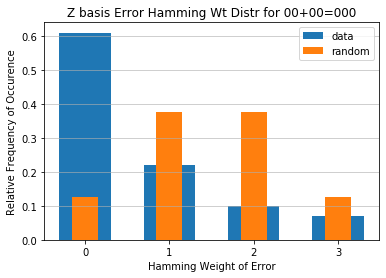

In [12]:
from scipy.special import comb

zeros_distribution = distributions[0]

rand_ans_distr = [comb(n_bits + 1, x)/2**(n_bits + 1) for x in range(len(zeros_distribution))]

x_labels = np.arange(0, len(zeros_distribution))
plt.bar(x_labels, zeros_distribution, width=0.61, align='center')
plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Z basis Error Hamming Wt Distr for 00+00=000')
#name = 'numbits'+str(n_bits) + '_basisZ' + '_shots' + str(nshots)
#plt.savefig(name)
plt.show()

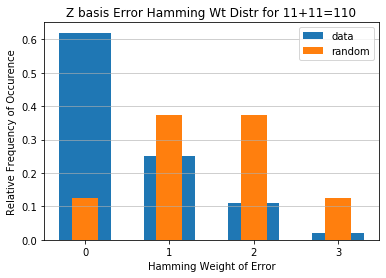

In [13]:
from scipy.special import comb

ones_distribution = distributions[-1]

rand_ans_distr = [comb(n_bits + 1, x)/2**(n_bits + 1) for x in range(len(zeros_distribution))]

x_labels = np.arange(0, len(ones_distribution))
plt.bar(x_labels, ones_distribution, width=0.61, align='center')
plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Z basis Error Hamming Wt Distr for 11+11=110')
#name = 'numbits'+str(n_bits) + '_basisZ' + '_shots' + str(nshots)
#plt.savefig(name)
plt.show()

## Plot average distribution over all summations; compare to random

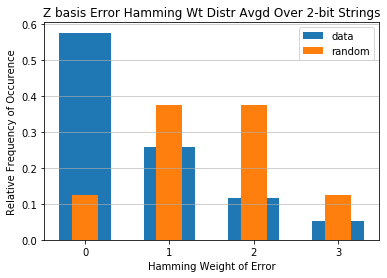

In [14]:
from scipy.special import comb

averaged_distr = np.mean(distributions, axis=0)

rand_ans_distr = [comb(n_bits + 1, x)/2**(n_bits + 1) for x in range(len(averaged_distr))]

x_labels = np.arange(0, len(averaged_distr))
plt.bar(x_labels, averaged_distr, width=0.61, align='center')
plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Z basis Error Hamming Wt Distr Avgd Over {}-bit Strings'.format(n_bits))
#name = 'numbits'+str(n_bits) + '_basisZ' + '_shots' + str(nshots)
#plt.savefig(name)
plt.show()

## Now do the same, but with addition in the X basis

In this section we do classical logic in the X basis. This means the inputs to the circuits are no longer $|0\rangle$ and $|1\rangle$, instead they are $|+\rangle = H|0\rangle$ and $|-\rangle = H|1\rangle$.

Originally all the logic was done with X, CNOT, and Toffoli gates. In this case we have to convert them to the corresponding gates in the X basis. E.g. 

CNOT = $|0\rangle\langle 0|\otimes I + |1\rangle\langle 1|\otimes X$ 

becomes

CNOT_in_X_basis = $(H\otimes I)$ CZ $(H\otimes I)$ = $|+\rangle\langle +|\otimes I + |-\rangle\langle -|\otimes Z$. 

**Note:** in some of the cells below there is a comment `# NBVAL_SKIP` this is used in testing to speed up our tests by skipping that particular cell.

100%|██████████| 16/16 [00:35<00:00,  2.23s/it]


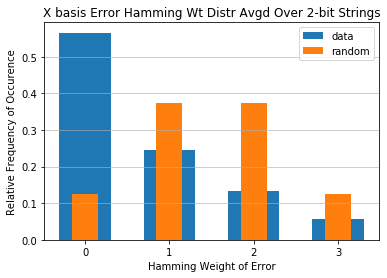

In [15]:
# NBVAL_SKIP

n_bits = 2
# set in_x_basis to true here
results = get_n_bit_adder_results(noisy_qc, n_bits, in_x_basis=True, show_progress_bar=True)
distributions = get_error_hamming_distributions_from_results(results)

averaged_distr = np.mean(distributions, axis=0)
x_labels = np.arange(0, len(averaged_distr))
plt.bar(x_labels, averaged_distr, width=0.61, align='center')
plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('X basis Error Hamming Wt Distr Avgd Over {}-bit Strings'.format(n_bits))
#plt.savefig(name)
plt.show()

## Error probablity to random guess probablity as a function of number of added bits

Here we compare the average probablity of the adder working as a function of input size (averaged over all possible input strings) to random guessing. To provide context we also compare this to the error probablity of the best input string (likely the all zero input string) and the worst input string (likely all ones).

In [16]:
# NBVAL_SKIP
summand_lengths = [1,2,3]
avg_n = []
med_n = []
min_n = []
max_n = []
rand_n = []

for n_bits in summand_lengths:
    results = get_n_bit_adder_results(noisy_qc, n_bits, show_progress_bar=True)
    output_len = n_bits + 1
    # success probablity average over all input strings
    avg_n.append(np.average(get_success_probabilities_from_results(results)))
    # median success probablity average over all input strings
    med_n.append(np.median(get_success_probabilities_from_results(results)))
    # success probablity input bit string with most errors
    min_n.append(np.min(get_success_probabilities_from_results(results)))
    # success probablity input bit string with least errors
    max_n.append(np.max(get_success_probabilities_from_results(results)))
    # sucess probablity of randomly guessing the correct answer
    rand_n.append(1 / 2**output_len)

100%|██████████| 64/64 [03:27<00:00,  3.24s/it]


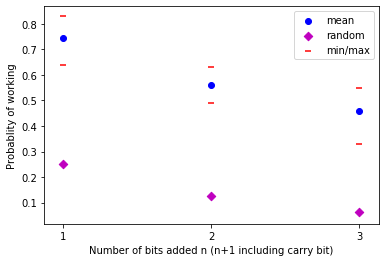

In [17]:
# NBVAL_SKIP
plt.scatter(summand_lengths, avg_n, c='b', label='mean')
plt.scatter(summand_lengths, rand_n, c='m', marker='D', label='random')
plt.scatter(summand_lengths, min_n, c='r', marker='_', label='min/max')
plt.scatter(summand_lengths, max_n, c='r', marker='_')
plt.xticks(summand_lengths)
plt.xlabel('Number of bits added n (n+1 including carry bit)')
plt.ylabel('Probablity of working')
plt.legend()
name = 'Pr_suc_fn_nbits' + '_basisZ' + '_shots' + str(nshots)
plt.savefig(name)
plt.show()

In [18]:
# NBVAL_SKIP
print('n bit:',  np.round(summand_lengths, 5))
print('average:',  np.round(avg_n, 5))
print('median:',  np.round(med_n, 5))
print('min:',  np.round(min_n, 5))
print('max:',  np.round(max_n, 5))
print('rand:',  np.round(rand_n, 5))

n bit: [1 2 3]
average: [0.745   0.55938 0.45969]
median: [0.755 0.555 0.47 ]
min: [0.64 0.49 0.33]
max: [0.83 0.63 0.55]
rand: [0.25   0.125  0.0625]
